In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%load_ext kedro.extras.extensions.ipython
%reload_kedro

The kedro.extras.extensions.ipython extension is already loaded. To reload it, use:
  %reload_ext kedro.extras.extensions.ipython


In [3]:
from mlsaft.extras.utils.molecular_fingerprints import (
    _canonicalize_smiles, compute_morgan_fingerprints
)
from mlsaft.extras.utils.pcsaft import create_pcsaft_parameters_from_gc
from mlsaft.extras.utils.plotting import remove_frame
from mlsaft.pipelines.train_models.nodes import cluster_split
from feos import eos, pcsaft, si
from rdkit import Chem
from tqdm import tqdm
import pandas as pd
from umap import UMAP
from sklearn.cluster import KMeans
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
from copy import copy

# Regressed Holdout Set

## Remove GC training data from SEPP holdout set

In [4]:
sepp_df = catalog.load("pcp_saft_sepp_pure_parameters")
sepp_smiles_set = set(sepp_df["smiles_1"])

2023-04-22 13:04:47,050 - kedro.io.data_catalog - INFO - Loading data from 'pcp_saft_sepp_pure_parameters' (CSVDataSet)...


In [5]:
dortmund_regressed = catalog.load("pcp_saft_regressed_pure_parameters")
dortmund_regressed_smiles_set = set(dortmund_regressed.smiles_1)

2023-04-22 13:04:47,102 - kedro.io.data_catalog - INFO - Loading data from 'pcp_saft_regressed_pure_parameters' (ParquetDataSet)...


In [6]:
dortmund_sepp_intersection = sepp_smiles_set.intersection(dortmund_regressed_smiles_set)
n_inter = len(dortmund_sepp_intersection)
print("Number of molecules in Dortmund regressed parameters and SEPP generated data:", n_inter)

Number of molecules in Dortmund regressed parameters and SEPP generated data: 350


In [7]:
# Group contribution training set SMILES
gc_train_df = catalog.load("gc_train_set")
gc_train_df["smiles"] = gc_train_df["smiles"].apply(_canonicalize_smiles)
gc_train_smiles = set(gc_train_df["smiles"].tolist())

# SEPP linear regression training set
sepp_train_df = catalog.load("sepp_train_set")
sepp_train_df["smiles"] = sepp_train_df["smiles"].apply(_canonicalize_smiles)
sepp_train_smiles  = set(sepp_train_df["smiles"].tolist())

2023-04-22 13:04:47,217 - kedro.io.data_catalog - INFO - Loading data from 'gc_train_set' (CSVDataSet)...
2023-04-22 13:04:47,231 - kedro.io.data_catalog - INFO - Loading data from 'sepp_train_set' (CSVDataSet)...


In [8]:
# Form test set
# Remove training sets from intersection of Dortmund and SEPP
base_test_smiles_set = dortmund_sepp_intersection - (sepp_train_smiles.union(gc_train_smiles))
base_test_smiles = list(base_test_smiles_set)
len(base_test_smiles)

247

* Associating holdout set (with SEPP, we are simplifying the associating considerations to make it compatible with existing PC-SAFT implementation; we just use the strongest associating site though SEPP can take into account all binary associating interactions)
* Non-associating holdout set

## Create test set by clustering

In [9]:
fps = compute_morgan_fingerprints(base_test_smiles)
split_idx, cluster_labels = cluster_split(fps, test_size=0.3)

Generating morgan fingerprints: 100%|██████████████████████████████████████████| 247/247 [00:00<00:00, 14914.32it/s]


In [10]:
test_smiles = [base_test_smiles[i] for i in split_idx["test_idx"]]
test_set_no_halogens = dortmund_regressed[dortmund_regressed["smiles_1"].isin(test_smiles)]
test_set_no_halogens["associating"].value_counts()

False    47
True     27
Name: associating, dtype: int64

## Sample some halogens for evaluations

### Identify halogens

In [11]:
smiles_list = []
mols = []
for smiles in tqdm(dortmund_regressed.smiles_1.dropna().unique()):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        Chem.SanitizeMol(mol)
        mol.UpdatePropertyCache(strict=False)
        smiles_list.append(Chem.MolToSmiles(mol))
        mols.append(mol)

100%|██████████████████████████████████████████████████████████████████████████| 988/988 [00:00<00:00, 23560.83it/s]


In [12]:
fragments_df = catalog.load("fragments")
fragments = {row["name"]: Chem.MolFromSmarts(row["smarts"]) for _,row in fragments_df.iterrows()}

2023-04-22 13:04:50,243 - kedro.io.data_catalog - INFO - Loading data from 'fragments' (CSVDataSet)...


In [13]:
def get_functional_groups(mol, fragments):
    return {label: len(mol.GetSubstructMatches(fragment)) for label, fragment in fragments.items()} 

functional_groups = [get_functional_groups(mol, fragments) for mol in mols]
functional_group_df = pd.DataFrame(functional_groups)
functional_group_df = functional_group_df.rename(
    columns=lambda s: s.lstrip(" ")
)

In [14]:
functional_group_df["smiles"] = [Chem.MolToSmiles(smi) for smi in mols]
halogens = functional_group_df[functional_group_df["halogens"]>0]

### Cluster halogens

In [15]:
fps = compute_morgan_fingerprints(halogens["smiles"])
reducer = UMAP(
    n_components=3,
    n_neighbors=15, 
    min_dist=0.1,
    metric="jaccard",
    random_state=0
)
X: np.ndarray = reducer.fit_transform(fps)  # type: ignore
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(X)

Generating morgan fingerprints: 100%|██████████████████████████████████████████| 179/179 [00:00<00:00, 13554.44it/s]


KMeans(n_clusters=3, random_state=0)

In [16]:
cluster_labels = kmeans.labels_ + 1
cluster_df = pd.DataFrame(X)
halogens["X1"] = X[:, 0]
halogens["X2"] = X[:, 1]
halogens["Cluster"] = cluster_labels

<Axes: xlabel='X1', ylabel='X2'>

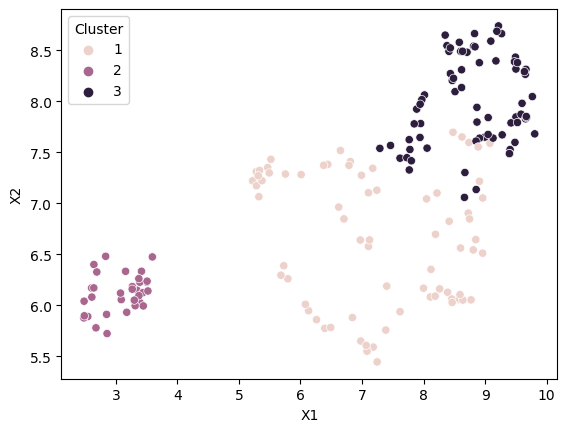

In [17]:
sns.scatterplot(
    data=halogens,
    x="X1",
    y="X2",
    hue="Cluster"
)

### Sample 3 molecules from each cluster 

In [18]:
halogen_test_molecules = halogens.groupby("Cluster").sample(3, random_state=0)
halogen_test_smiles = set(halogen_test_molecules["smiles"].tolist())
test_smiles += (list(halogen_test_smiles))

In [19]:
test_smiles_df = pd.DataFrame(test_smiles, columns=["smiles_1"])

In [22]:
test_smiles_df.shape

(83, 1)

## Write out results

In [28]:
final_test_df = dortmund_regressed[
    ["name", "smiles_1"]
].drop_duplicates().merge(test_smiles_df, on="smiles_1", how="right")
final_test_df

,name,smiles_1
0,2-Methylfuran,Cc1ccco1
1,Diethylenetriamine,NCCNCCN
2,Tetrahydropyran,C1CCOCC1
3,Cyclohexylamine,NC1CCCCC1
4,trans-2-Hexenal,CCC/C=C/C=O
...,...,...
78,3-Bromo-1-propene,C=CCBr
79,o-Dichlorobenzene,Clc1ccccc1Cl
80,Phosphoryl chloride,O=P(Cl)(Cl)Cl
81,sec-Butyl chloride,CCC(C)Cl


In [29]:
catalog.save("final_holdout_set", final_test_df)

2023-04-22 13:09:38,861 - kedro.io.data_catalog - INFO - Saving data to 'final_holdout_set' (CSVDataSet)...


## Check GC resolution

In [30]:
pure_gc_data = catalog.load("pure_gc_data")
segment_data = catalog.load("sauer2014_homo_segments_gc_data")

2023-04-22 13:10:03,327 - kedro.io.data_catalog - INFO - Loading data from 'pure_gc_data' (JSONDataSet)...
2023-04-22 13:10:03,329 - kedro.io.data_catalog - INFO - Loading data from 'sauer2014_homo_segments_gc_data' (JSONDataSet)...


In [31]:
segment_records = [
    pcsaft.SegmentRecord.from_json_str(json.dumps(d)) for d in segment_data
]
chemical_records = [
    pcsaft.ChemicalRecord.from_json_str(json.dumps(d)) for d in pure_gc_data
]

In [32]:
parameters = create_pcsaft_parameters_from_gc(
    list(test_smiles),
    segment_records=segment_records,
    pure_chemical_records=chemical_records,
    skip_failures=False
)

In [38]:
n_gc_resolved = len([p for p in parameters.values() if p])
print("Number resolved by gc method:", n_gc_resolved)

Number resolved by gc method: 63


# End-to-End Holdout Set

- Ensure that the GC and SEPP training molecules are not in the test set
- Seed the test set with data from SEPP and then expand with halogens

In [227]:
# Load dortmund smiles
dortmund = catalog.load("dortmund_base_pure_component_filtered")
dortmund_smiles = dortmund.smiles_1.unique()
print("Total number of moleucles in dortmund:", len(dortmund_smiles))

2023-03-30 21:33:07,398 - kedro.io.data_catalog - INFO - Loading data from 'dortmund_base_pure_component_filtered' (ParquetDataSet)...
Total number of moleucles in dortmund: 10144


In [212]:
# Smiles of molecules that worked with SEPP
sepp = catalog.load("pcp_saft_sepp_pure_parameters")
sepp_dortmund_smiles = set(sepp.smiles_1.tolist())
test_smiles = copy(sepp_dortmund_smiles)
print("Starting test size:", len(test_smiles))

2023-03-30 16:44:41,048 - kedro.io.data_catalog - INFO - Loading data from 'pcp_saft_sepp_pure_parameters' (CSVDataSet)...
Starting test size: 1200


In [213]:
# Load fragements
fragments_df = catalog.load("fragments")
fragments = {row["name"]: Chem.MolFromSmarts(row["smarts"]) for _,row in fragments_df.iterrows()}


# Identify halogens
def get_functional_groups(mol, fragments):
    return {label: len(mol.GetSubstructMatches(fragment)) for label, fragment in fragments.items()} 
mols = [Chem.MolFromSmiles(smi) for smi in dortmund_smiles]
functional_groups = [get_functional_groups(mol, fragments) for mol in mols]
functional_group_df = pd.DataFrame(functional_groups)
functional_group_df = functional_group_df.rename(
    columns=lambda s: s.lstrip(" ")
)
functional_group_df["smiles"] = dortmund_smiles
halogens = functional_group_df[functional_group_df["halogens"]>0]
print(f"Total number of halogens:", len(halogens))

# Sample 100 random halogens and add to test set
halogens_sampled = halogens.sample(100, random_state=10)
halogen_sampled_smiles = set(halogens_sampled.smiles)
test_smiles = test_smiles.union(halogen_sampled_smiles)
print("Number of halogens sampled:", len(halogen_sampled_smiles))
print("Test set size:", len(test_smiles))

2023-03-30 16:44:44,648 - kedro.io.data_catalog - INFO - Loading data from 'fragments' (CSVDataSet)...


[16:44:45] WARNING: not removing hydrogen atom without neighbors


Total number of halogens: 3180
Number of halogens sampled: 100
Test set size: 1300


In [214]:
# Remove SEPP training set from the test set
sepp_train_set = catalog.load("sepp_train_set")
sepp_train_smiles = set(sepp_train_set["smiles"])
test_smiles -= sepp_train_smiles

# Remove GC training set from the test set
gc_train_set = catalog.load("gc_train_set")
gc_train_smiles = set(gc_train_set["smiles"])
test_smiles -= gc_train_smiles
print("After removing SEPP and GC training sets:", len(test_smiles))

2023-03-30 16:45:04,624 - kedro.io.data_catalog - INFO - Loading data from 'sepp_train_set' (CSVDataSet)...
2023-03-30 16:45:04,628 - kedro.io.data_catalog - INFO - Loading data from 'gc_train_set' (CSVDataSet)...
After removing SEPP and GC training sets: 1146


In [226]:
test_set = dortmund[["Component", "smiles_1"]].drop_duplicates()
test_set = test_set[test_set["smiles_1"].isin(list(test_smiles))]
# test_set = test_set.rename(columns={"smiles_1": "smiles"})
test_set.to_csv("../data/02_intermediate/e2e_holdout_set.csv", index=False)

In [222]:
fps = compute_morgan_fingerprints(dortmund_smiles)
reducer = UMAP(
    n_components=2,
    n_neighbors=10, 
    min_dist=0.1,
    metric="jaccard",
    random_state=0
)
print("Fitting UMAP")
X: np.ndarray = reducer.fit_transform(fps)  # type: ignore

Generating morgan fingerprints: 100%|███████████████████████████████████████| 10144/10144 [00:01<00:00, 7867.22it/s]


Fitting UMAP


In [223]:
df = pd.DataFrame(X, columns=["UMAP 1", "UMAP 2"])
df["smiles"] = dortmund_smiles
test_smiles_list = test_set["smiles"].tolist()
df["test"] = df["smiles"].apply(lambda s: s in test_smiles_list)

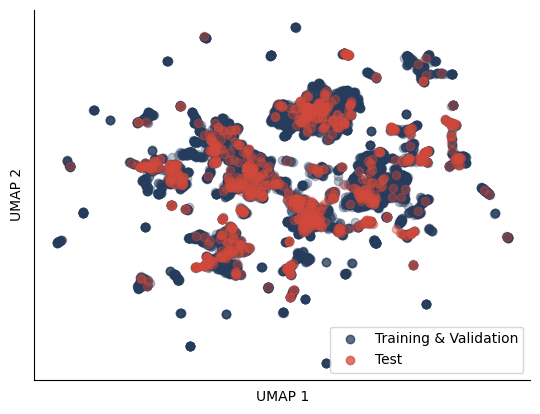

In [228]:
fig, ax = plt.subplots()
df_train = df[df["test"]==False]
ax.scatter(df_train["UMAP 1"], df_train["UMAP 2"],c="#263C5C", alpha=0.3, label="Training & Validation")
# c="#C28079",edgecolors="#9F5149",
df_test = df[df["test"]==True]
ax.scatter(df_test["UMAP 1"], df_test["UMAP 2"],c="#D14A3B", alpha=0.4, label="Test")
# c="#D3DABB", edgecolors="#97A85E", 
leg = ax.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(0.75)
ax.tick_params(length=0.0)
ax.set_xticklabels([])
ax.set_yticklabels([])
remove_frame(ax, sides=["top", "right"])
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
fig.savefig("../data/08_reporting/e2e_splits/umap_train_test.png", dpi=300)